In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
%matplotlib inline
from __future__ import division
from __future__ import print_function
from scipy.optimize import curve_fit
import os

In [2]:
datadirectory = 'data_membrane_meas'
def makename(filename):
    return os.path.join(datadirectory,filename)

In [6]:
class ExposureAnalysis(object):
    '''Data and fit parameters for membrane thickness measurements as a function of layer exposure time.
    See ipython notebook "150324_ab_calcs.ipynb" for detailed definitions.
    
    Key results are the following instance variables:
        layerexptime - array of layer exposure times in seconds
        avethickness - array of average layer thicknesses in um
        stdthickness - array of standard deviation of layer thicknesses in um
        normlayerexptime - array of layer exposure times normalized by T_c
        normthickness - array of average layer thicknesses normalized by h_a
        h_a - polymerization depth in um for normalized exposure time of e. It is 
              also equal to 1/(absorption coefficient)
        T_c - critical exposure time in seconds, i.e., the exposure time required
              for enough dose to just polymerize the resin at z=0.
        
    Other variables:
        data - 5 columns:
            0: layer exposure time (seconds)
            1: average measured membrane thickness (um)
            2: standard deviation of measured membrane thickness (um)
            3: normalized layer exposure time (normalized by critical time, T_c)
            4: normalized membrane thickness (normalized by h_a)
        fitparams:
            0: h_a (um)
            1: T_c (seconds)'''
    
    def __init__(self, data=None, filepathname=''):
        if data is None:
            if filepathname == '':
                print('ERROR: NO DATA OR FILENAME SPECIFIED FOR membraneThickness OBJECT')
                return
            else:
                self.rawmeasdata_pix = np.loadtxt(filepathname, delimiter=',', skiprows=1)
                layerexptimes = self.rawmeasdata_pix[0,:]
                self.rawmeasdata_um, tempave, tempstd = self.calc_ave_stdev_membrane_thickness_um(
                    self.rawmeasdata_pix[1:,:])
                self.data = np.array([layerexptimes,tempave,tempstd]).T
        else:
            self.data = data
            self.rawmeasdata_pix = None
            self.rawmeasdata_um = None
        # Calculate curve fit
        self.fitparams, self.covmatrix = curve_fit(self.membthickfunc, self.data[:,0], self.data[:,1])
        self.std_devs = np.sqrt(self.covmatrix.diagonal())
        # Add a column for layer exposure time divided by the critical time (i.e., normalized layer exposure time)
        temp = self.data[:,0]/self.fitparams[1]
        self.data = np.c_[self.data, temp]
        # Add a column for normalized membrane thickness
        temp = self.data[:,1]/self.fitparams[0]
        self.data = np.c_[self.data, temp]
        self.layerexptime = self.data[:,0]
        self.avethickness = self.data[:,1]
        self.stdthickness = self.data[:,2]
        self.normlayerexptime = self.data[:,3]
        self.normthickness = self.data[:,4]
        self.h_a = self.fitparams[0]
        self.T_c = self.fitparams[1]
        self.fit = self.membthickfunc(self.layerexptime,self.h_a,self.T_c)
    
    def membthickfunc(self,t,a,b):
        return a*np.log(t/b)
    
    def calc_ave_stdev_membrane_thickness_um(self,rawdata):
        # Replace zeros with NaN's
        rawdata[rawdata == 0] = np.NaN
        # Convert from pixels to microns (assumes pixel measurements are in x-direction)
        rawdata = rawdata * 1.8244
        # Calculate column averages and standard deviations
        columnaverages = np.nanmean(rawdata, axis=0)
        columnstdev = np.nanstd(rawdata, axis=0)
        return rawdata, columnaverages, columnstdev

In [5]:
a = ExposureAnalysis(filepathname=makename('150415_10irga_01btex.csv'))
print(a.data)
print(a.fitparams)
print(a.h_a,a.T_c)
print(a.layerexptime)

[[  2.00000000e+00   6.83846541e+02   2.33027140e+01   8.64015668e+00
    2.27743485e+00]
 [  1.00000000e+00   3.92854741e+02   8.72831309e+00   4.32007834e+00
    1.30833604e+00]
 [  5.00000000e-01   2.15281633e+02   1.65899401e+01   2.16003917e+00
    7.16958940e-01]
 [  2.50000000e-01   4.92653678e+01   1.25350024e+01   1.08001959e+00
    1.64069946e-01]]
[  3.00270518e+02   2.31477284e-01]
300.270518292 0.23147728369
[ 2.    1.    0.5   0.25]


/Users/nordin/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:50: RuntimeWarning: invalid value encountered in log


/Users/nordin/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:61: RuntimeWarning: invalid value encountered in log


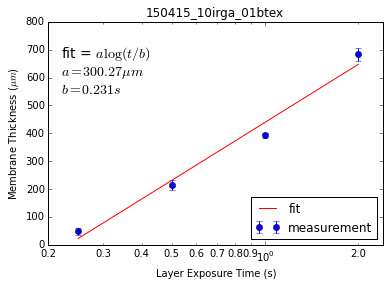

In [33]:
def plot_avethickness_vs_dose(filename,xlim=None,textloc=None,title='',savefig=False):
    
    data = ExposureAnalysis(filepathname=makename(filename))
    
    if title == '':
        title = filename.rsplit( ".", 1 )[0]

    fig, ax = plt.subplots()
    ax.set_xscale('log')
    ax.errorbar(data.layerexptime, data.avethickness, data.stdthickness, 
                linestyle='None', marker='o', label='measurement')
    ax.plot(data.layerexptime, data.fit, 'r-', label='fit')
    ax.xaxis.set_minor_formatter(FormatStrFormatter("%.1f"))
    if xlim is None:
        tempmin,tempmax = min(data.layerexptime), max(data.layerexptime)
        xlim = (tempmin*0.8,tempmax*1.2)
    ax.set_xlim(*xlim)
    ax.legend(loc=4)
    fittext = 'fit = $a \log(t/b)$\n$a={:.2f} \mu m$\n$b={:.3f}s$'.format(data.h_a,data.T_c)
    if textloc is None:
        textloc = (xlim[0]*1.1, max(data.avethickness*0.8))
    ax.text(textloc[0],textloc[1],fittext,fontsize=14)
    ax.set_xlabel('Layer Exposure Time (s)')
    ax.set_ylabel('Membrane Thickness ($\mu m$)')
    ax.set_title(title)
    if savefig:
        figfilename = filename.rsplit( ".", 1 )[0]
        plt.savefig(makename(figfilename))

plot_avethickness_vs_dose('150415_10irga_01btex.csv',savefig=True)

/Users/nordin/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:61: RuntimeWarning: invalid value encountered in log


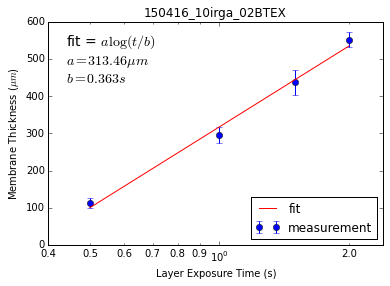

In [34]:
plot_avethickness_vs_dose('150416_10irga_02BTEX.csv',savefig=True)

/Users/nordin/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:61: RuntimeWarning: invalid value encountered in log


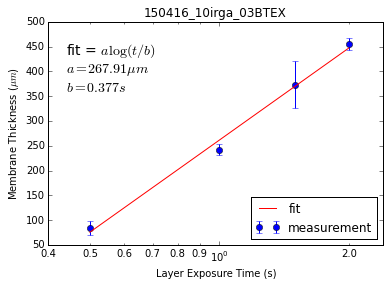

In [35]:
plot_avethickness_vs_dose('150416_10irga_03BTEX.csv',savefig=True)

/Users/nordin/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:61: RuntimeWarning: invalid value encountered in log


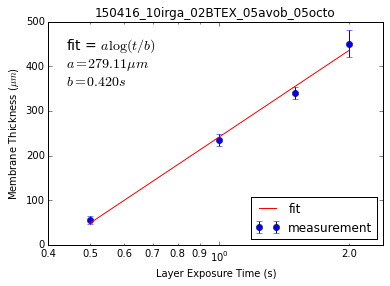

In [36]:
plot_avethickness_vs_dose('150416_10irga_02BTEX_05avob_05octo.csv',savefig=True)

/Users/nordin/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:61: RuntimeWarning: invalid value encountered in log


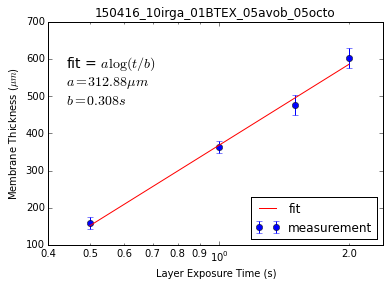

In [37]:
plot_avethickness_vs_dose('150416_10irga_01BTEX_05avob_05octo.csv',savefig=True)

/Users/nordin/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:61: RuntimeWarning: invalid value encountered in log


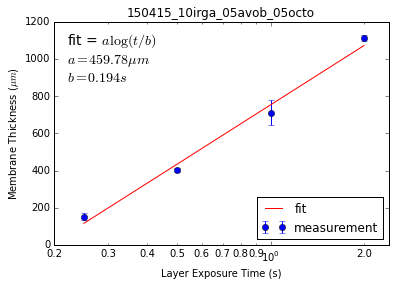

In [38]:
plot_avethickness_vs_dose('150415_10irga_05avob_05octo.csv',savefig=True)